#Relative Value Factor Algorithm

By Gil Wassermann

Strategy taken from "130/30: The New Long-Only" by Andrew Lo and Pankaj Patel

Part of the Quantopian Lecture Series:
* www.quantopian.com/lectures
* github.com/quantopian/research_public

Notebook released under the Creative Commons Attribution 4.0 License. Please do not remove this attribution.

In the last notebook, we looked at traditional value factors that evaluated whether or not a stock could be considered cheap. However, many of the metrics in this last algorithm ignore subtleties that exist between industry groups. In this notebook, we will refine and add to these factors in order to devise metrics that are industry-relative. For this algorithm we will make use of Pipeline's classifiers and zscore method, which are described in detail here (https://www.quantopian.com/posts/pipeline-classifiers-are-here).

First, let us import all necessary libraries and functions for this algorithm. These are similar to those in the Traditional Value Factor Algorithm, with the notable inclusion of Sector, a classifier.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from quantopian.pipeline.classifiers.morningstar import Sector
from quantopian.pipeline import Pipeline
from quantopian.pipeline.data.builtin import USEquityPricing
from quantopian.research import run_pipeline
from quantopian.pipeline.data import morningstar
from quantopian.pipeline.factors import CustomFactor

#Relative Value

The metrics used to create this strategy are given by Lo/Patel as:

* Industry-Relative Price to Trailing 12-Month Sales
* Industry-Relative Price to Trailing 12-Month Earnings
* Industry-Relative Price to Trailing 12-Month Cash Flows

While many of these metrics may seem similar to those of the last notebook, the key addition is the fact that they are taken in the context of their own industry. In this notebook, we will see how this industry-relative approach captures certain nuances that more general factors miss.

##Industry-Relative Price to TTM Sales

This is calculated as a simple ratio between price per share and trailing 12-month (TTM) sales. This data will eventually be standardized over industry groups. The standardization procedure is explained later in the notebook.

Let us create a factor for this metric and have a look at the data. For an introduction to Pipeline Factors, have a look at (https://www.quantopian.com/posts/quantopian-lecture-series-long-slash-short-traditional-value-case-study)

NB: Like the previous notebook, we are using Morningstar's built-in Price to Sales Ratio as an approximation of Price to TTM Sales for speed of computation.

In [2]:
# Custom Factor 1 : Price to Trailing 12 Month Sales       
class Price_to_TTM_Sales(CustomFactor):
    inputs = [morningstar.valuation_ratios.ps_ratio]
    window_length = 1
    
    def compute(self, today, assets, out, ps):
        out[:] = ps[-1]

# create pipeline
temp_pipe_1 = Pipeline()

# add our factor
temp_pipe_1.add(Price_to_TTM_Sales(), 'Price / TTM Sales')

# add sector classifier
temp_pipe_1.add(Sector(), 'Sector')

# get data
temp_res_1 = run_pipeline(temp_pipe_1, '2015-06-06', '2015-06-06')

# show first 15 rows
temp_res_1.head(15)

Price / TTM Sales  Sector
2015-06-08 00:00:00+00:00 Equity(2 [AA])                 0.6254     101
                          Equity(21 [AAME])              0.4797     103
                          Equity(24 [AAPL])              3.6187     311
                          Equity(25 [AA_PR])                NaN     101
                          Equity(31 [ABAX])              5.9388     206
                          Equity(39 [DDC])               1.7552     101
                          Equity(41 [ARCB])              0.3431     310
                          Equity(52 [ABM])               0.3650     310
                          Equity(53 [ABMD])             11.7812     206
                          Equity(62 [ABT])               3.6266     206
                          Equity(64 [ABX])               1.3845     101
                          Equity(66 [AB])               12.9702     103
                          Equity(67 [ADSK])              4.8664     311
                          Equity(69 [ACAT])              0.6112     102
                          Equity(70 [VBF])                  NaN      -1

Before performing analysis on this data, let us look at the Sector column. This is an example of a Pipeline Classifier. Whereas a CustomFactor outputs numerical information, a Classifier ouputs categorical information. For example, Sector can take on one of a certain number of discrete integers (11 as of writing), each of which corresesponds to the industry of the company that has issued the equity. These are listed fully in https://www.quantopian.com/help. 

As an example, let us examine the differences between two industries: Retail (here, given by code 102) and Technology (311). Retail companies tend to have small profit margins, whereas tech companies tend to have large profit margins. You make a much larger mark-up on a microchip than an paperclip. This is reflected in the Price to Sales Ratio. Tech sales dollars are valued more, as they generate more profit for the company. Therefore, investors are willing to pay a higher price for those sales. This increases the numerator of the Price to Sales equation, making the ratio larger for companies with big profit margins.  

NB: We look at the quartiles of Price to Sales Ratios in order to limit the effect of outliers. Certain companies may employ peculiar strategies that lead to extreme values that could distort metrics like the mean or standard deviation.

In [4]:
# Separate sectors into two data frames
retail_df = temp_res_1[temp_res_1['Sector'] == 102]['Price / TTM Sales']
tech_df = temp_res_1[temp_res_1['Sector'] == 311]['Price / TTM Sales']

# get quartiles and print results
print 'Retail Quartiles: \n' + str(retail_df.quantile([0.25, 0.5, 0.75])) + '\n'
print 'Tech Quartiles: \n' + str(tech_df.quantile([0.25, 0.5, 0.75]))

Retail Quartiles: 
0.25    0.5925
0.50    1.1198
0.75    2.0755
dtype: float64

Tech Quartiles: 
0.25    1.045375
0.50    2.120600
0.75    4.023625
dtype: float64


Indeed, the median Price to Rales Ratio for tech companies is almost double that of retail companies, which agrees with our narrative explanation. From this data, it is clear that comparisons of Price to Sales Ratios are only really valid when they are conducted within a single industry. This is because a good Price to Sales Ratio for one industry might be terrible for another. 

##Industry-Relative Price to TTM Earnings

This is calculated as a simple ratio between price per share and TTM earnings per share standardized over industry groups.

At first glance this might look like a better metric than the Price to Sales Ratio as earnings take both revenue and cost into account. However, Price to Earnings Ratios can also be misleading as the accounting conventions used to calculate it are quite vague.

Although it is possible for two companies in the same industry to have completely different approaches to calculating their earnings, companies in the same sector are more likely to use similar methodologies to eachother in order to maintain comparability. Intra-industry calculations are by no means identical, however they are more likely to be similar than inter-industry comparisons.

Let us load up the data for this factor and plot the box and whisker plots for each sector. Box and whisker plots (known as boxplots in most Python libraries) are a quick and easy way to have a look at the distribution of data points. The "whiskers" represent the high and low values while the "box" designates the 25th and 75th percentiles (interquartile range). The 50th percentile (median) is represented by a notch within the "box". Once again, we will use the Morningstar built-in fundamental as an approximation to the TTM transformation. 

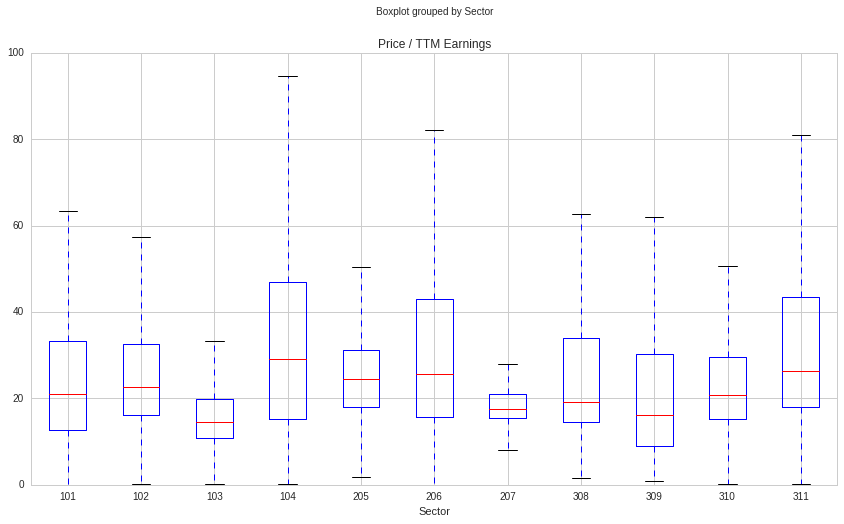

In [5]:
# Custom Factor 2 : Price to Trailing 12 Month Earnings
class Price_to_TTM_Earnings(CustomFactor):
    inputs = [morningstar.valuation_ratios.pe_ratio]
    window_length = 1
    
    def compute(self, today, assets, out, pe):
        out[:] = pe[-1]
        
temp_pipe_2 = Pipeline() 
temp_pipe_2.add(Price_to_TTM_Earnings(), 'Price / TTM Earnings')
temp_pipe_2.add(Sector(), 'Sector')
temp_res_2 = run_pipeline(temp_pipe_2, '2015-06-06', '2015-06-06')

# clean extreme data points
earnings_frame = temp_res_2[temp_res_2['Price / TTM Earnings'] < 100]

# create boxplot by sector
earnings_frame.boxplot(column='Price / TTM Earnings', by='Sector');

From this graph it is easy to see that the makeup of Price to Earnings Ratios for different sectors differs substantially. Therefore, an industry-relative metric will be a more discerning value than a universe-wide one.

##Industry-Relative Price to TTM Cash Flows

This is calculated as a simple ratio between price per share and TTM free cash flows per share standardized over industry groups.

Unlike earnings, a company's cash flows are a very definite metric and is not subject to accounting irregularities. However, this, too, can benefit from an industry-relative approach as different industries have different regular cash flows.

We will apply the same methodology as the previous factor in order to examine the data.

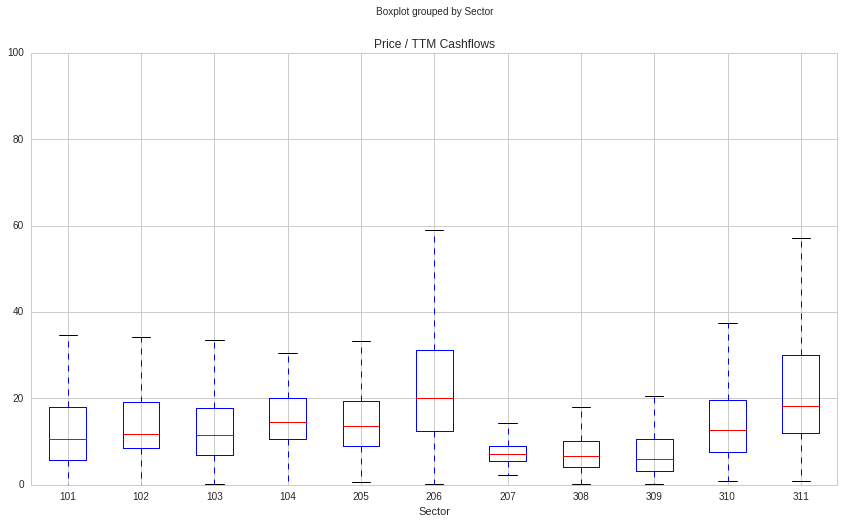

In [6]:
# Custom Factor 3 : Price to Trailing 12 Month Cash Flows
class Price_to_TTM_Cashflows(CustomFactor):
    inputs = [morningstar.valuation_ratios.pcf_ratio]
    window_length = 1
    
    def compute(self, today, assets, out, pcf):
        out[:] = pcf[-1] 
        
temp_pipe_3 = Pipeline() 
temp_pipe_3.add(Price_to_TTM_Cashflows(), 'Price / TTM Cashflows')
temp_pipe_3.add(Sector(), 'Sector')
temp_res_3 = run_pipeline(temp_pipe_3, '2015-06-06', '2015-06-06')

# clean extreme data points
cashflows_frame = temp_res_3[temp_res_3['Price / TTM Cashflows'] < 100]

# create boxplot by sector
cashflows_frame.boxplot(column='Price / TTM Cashflows', by='Sector');

The box and whisker diagram here shows that, much like the Price to Sales Ratio, a good Price to Cash Flows Ratio differs from industry to industry. Therefore, this, too, will benefit from an industry-relative calculation.

One thing to note is that cashflows and earnings are not related. For example, consider Sector 104, which represents Real Estate companies. Here, the spread of earnings for these companies is very wide, perhaps due to the high volatility of the industry: the real estate companies that do well do very well indeed, while those that do not perform do poorly. However, the spread is much tigher on the Price to Cash Flows Ratio, caused by steady and predictable cash flows (the amount of money needed to complete a building project is often known, or at least carefully estimated, beforehand).

##Standardization

We have seen, now, that comparisons across industries are innacurate at best and misleading at worst. We, therefore, need a different approach in order to rank the entire universe of equities. To do this, we will standardize each equity's ratios within its sector. 

To standardize a dataset, you need to

1. calculate the mean and standard deviation of that dataset
2. for each value in the dataset, subtract the mean and divide it by the standard deviation

Standardization is a very common transformation in statistics. The value it gives (the z-score) can be interpreted as the number of standard deviations a measurement is from the mean of its dataset. The good news is that z-scores from different datasets can be compared to eachother as they have the same unit of measurement. Lets have a look at the histograms of the Price to Sales Ratios in the retail and tech industries in order to examine this metric further.

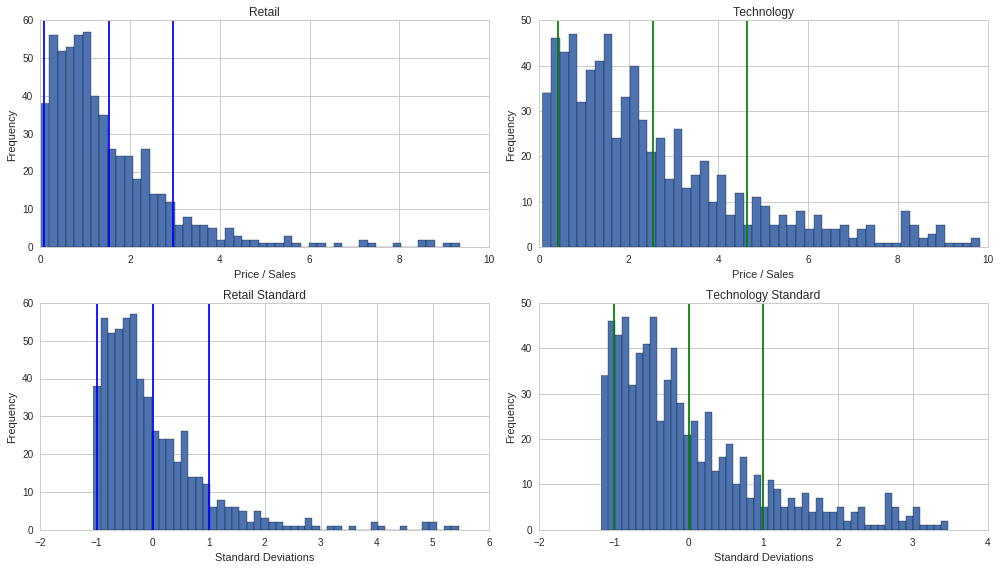

In [7]:
# clean data, necessary as using mean and standard deviation
retail_df = retail_df[retail_df < 10]
tech_df = tech_df[tech_df < 10]

# summary stats necessary for calculation
retail_mean = retail_df.mean()
retail_std = retail_df.std()
tech_mean = tech_df.mean()
tech_std = tech_df.std()

# standardize the data
retail_standard = (retail_df - retail_mean) / retail_std
tech_standard = (tech_df - tech_mean) / tech_std

# create a grid of plots
fig, axes = plt.subplots(nrows=2, ncols=2)
# name each set of axes
ax_retail, ax_tech, ax_retail_st, ax_tech_st = axes.flat
# number of bins for histograms
bins = 50

# retail
ax_retail.hist(retail_df, bins=bins)
ax_retail.axvline(retail_mean, color='blue')
ax_retail.axvline(retail_mean - retail_std, color='blue')
ax_retail.axvline(retail_mean + retail_std, color='blue')
ax_retail.set_xlabel('Price / Sales')
ax_retail.set_ylabel('Frequency')
ax_retail.set_title('Retail')

# tech
ax_tech.hist(tech_df, bins=bins, stacked=True)
ax_tech.axvline(tech_mean, color='green')
ax_tech.axvline(tech_mean - tech_std, color='green')
ax_tech.axvline(tech_mean + tech_std, color='green')
ax_tech.set_xlabel('Price / Sales')
ax_tech.set_ylabel('Frequency')
ax_tech.set_title('Technology')

# retail standardized
ax_retail_st.hist(retail_standard, bins=bins)
ax_retail_st.axvline(0, color='blue')
ax_retail_st.axvline(-1, color='blue')
ax_retail_st.axvline(1, color='blue')
ax_retail_st.set_xlabel('Standard Deviations')
ax_retail_st.set_ylabel('Frequency')
ax_retail_st.set_title('Retail Standard')

# tech standardized
ax_tech_st.hist(tech_standard, bins=bins, stacked=True)
ax_tech_st.axvline(0, color='green')
ax_tech_st.axvline(-1, color='green')
ax_tech_st.axvline(1, color='green')
ax_tech_st.set_xlabel('Standard Deviations')
ax_tech_st.set_ylabel('Frequency')
ax_tech_st.set_title('Technology Standard')

# prevent text overlap
fig.tight_layout()

As can be seen above, standardization allows comparison between two datasets. While the companies in the technology sector have larger and more spread out Price to Sales Ratios than those in the retail sector, standardization allows an analyst to compare the relative extremity of values between datasets. Now we *can* compare values across setors

NB: Standardization is technically only effective if the underlying values are normally distributed. However, observation of the graphs suggests that the distribution of Price to Sales Ratios is perhaps exponential or lognormal (on account of the 0 lower bound and the strong positive skew). Therefore, this cross industry comparison can only be seen as an approximation.

##Full Pipeline

To standardize our full Pipeline, we need to calculate the mean and standard deviation of each ratio in each industry. Then for each valuation ratio of each equity, we will need to subtract its industry's mean and divide by its industry's standard deviation. This sounds like it would need a very computationally involved bit of code. However, Pipeline's built-in zscore() method gives this potentially problematic code a one-line solution. For a full explanation of the zscore function see https://www.quantopian.com/posts/pipeline-classifiers-are-here.

As with the previous notebook, we will also make a factor to create a proxy S&P500 for the ranking logic.

Let us run the full Pipeline.

In [8]:
# This factor creates the synthetic S&P500
class SPY_proxy(CustomFactor):
    inputs = [morningstar.valuation.market_cap]
    window_length = 1
    
    def compute(self, today, assets, out, mc):
        out[:] = mc[-1]
        
        
# this function returns a pipeline that downloads all data necessary for the algo
def Data_Pull():

    # create the piepline for the data pull
    Data_Pipe = Pipeline()
    
    # create sector partitions
    sector = Sector()
    
    # create SPY proxy
    Data_Pipe.add(SPY_proxy(), 'SPY Proxy')
    
    # Price / TTM Sales grouped by Industry
    sales_grouped = Price_to_TTM_Sales().zscore(groupby=sector)
    
    # Price / TTM Earnings grouped by Industry
    earnings_grouped = Price_to_TTM_Earnings().zscore(groupby=sector)
    
    # Price / TTM Cashflows grouped by Industry
    cashflows_grouped = Price_to_TTM_Cashflows().zscore(groupby=sector)
    
    # add Price / TTM Sales to Pipeline
    Data_Pipe.add(sales_grouped, 'Price / TTM Sales')
    
    # add Price / TTM Earnings to Pipeline
    Data_Pipe.add(earnings_grouped, 'Price / TTM Earnings')
    
    # add Price / TTM Cashflows to Pipeline
    Data_Pipe.add(cashflows_grouped, 'Price / TTM Cashflows')
    
    return Data_Pipe

results = run_pipeline(Data_Pull(), '2015-06-06', '2015-06-06')
results.head(20)

Price / TTM Cashflows  \
2015-06-08 00:00:00+00:00 Equity(2 [AA])                  -0.228260   
                          Equity(21 [AAME])               -0.065546   
                          Equity(24 [AAPL])               -0.102235   
                          Equity(25 [AA_PR])                    NaN   
                          Equity(31 [ABAX])               -0.092681   
                          Equity(39 [DDC])                -0.242844   
                          Equity(41 [ARCB])               -0.141794   
                          Equity(52 [ABM])                -0.100783   
                          Equity(53 [ABMD])               -0.069797   
                          Equity(62 [ABT])                -0.101121   
                          Equity(64 [ABX])                -0.232389   
                          Equity(66 [AB])                 -0.067308   
                          Equity(67 [ADSK])               -0.090698   
                          Equity(69 [ACAT])               -0.206946   
                          Equity(70 [VBF])                      NaN   
                          Equity(76 [TAP])                -0.163318   
                          Equity(84 [ACET])               -0.039401   
                          Equity(86 [ACG])                      NaN   
                          Equity(88 [ACI])                -0.004039   
                          Equity(100 [IEP])                0.044639   

                                              Price / TTM Earnings  \
2015-06-08 00:00:00+00:00 Equity(2 [AA])                 -0.137305   
                          Equity(21 [AAME])              -0.061818   
                          Equity(24 [AAPL])              -0.254608   
                          Equity(25 [AA_PR])                   NaN   
                          Equity(31 [ABAX])              -0.137099   
                          Equity(39 [DDC])               -0.135980   
                          Equity(41 [ARCB])              -0.274208   
                          Equity(52 [ABM])               -0.230880   
                          Equity(53 [ABMD])              -0.247635   
                          Equity(62 [ABT])               -0.206759   
                          Equity(64 [ABX])               -0.158385   
                          Equity(66 [AB])                -0.119138   
                          Equity(67 [ADSK])               0.070003   
                          Equity(69 [ACAT])              -0.042954   
                          Equity(70 [VBF])                     NaN   
                          Equity(76 [TAP])               -0.135310   
                          Equity(84 [ACET])              -0.130085   
                          Equity(86 [ACG])                     NaN   
                          Equity(88 [ACI])               -0.151373   
                          Equity(100 [IEP])              -0.132753   

                                              Price / TTM Sales     SPY Proxy  
2015-06-08 00:00:00+00:00 Equity(2 [AA])              -0.061063  1.527980e+10  
                          Equity(21 [AAME])           -0.055851  7.920730e+07  
                          Equity(24 [AAPL])           -0.051943  7.452470e+11  
                          Equity(25 [AA_PR])                NaN           NaN  
                          Equity(31 [ABAX])           -0.054737  1.197080e+09  
                          Equity(39 [DDC])            -0.061062  1.607340e+09  
                          Equity(41 [ARCB])           -0.045524  9.029610e+08  
                          Equity(52 [ABM])            -0.045505  1.845380e+09  
                          Equity(53 [ABMD])           -0.054732  2.642370e+09  
                          Equity(62 [ABT])            -0.054739  7.247270e+10  
                          Equity(64 [ABX])            -0.061063  1.361500e+10  
                          Equity(66 [AB])             -0.046536  3.136030e+09  
                          Equity(67 [ADSK])

Now, we will use the same metric to combine these values as in the last notebook. The one large difference between these methodologies is the ranking of the final scores. For each of the ratios here, a low value is considered to be an attractive investment. Therefore we rank the values in ascending order so that the "best" stocks are still at the head of the data series and the "worst" are in the tail. This ranking occurs in the composite_score function.

In [9]:
# limit effect of outliers
def filter_fn(x):
    if x <= -10:
        x = -10.0
    elif x >= 10:
        x = 10.0
    return x   

# standardize using mean and sd of S&P500
def standard_frame_compute(df):
    
    # basic clean of dataset to remove infinite values
    df = df.replace([np.inf, -np.inf], np.nan)
    df = df.dropna()
    
    # need standardization params from synthetic S&P500
    df_SPY = df.sort(columns='SPY Proxy', ascending=False)

    # create separate dataframe for SPY
    # to store standardization values
    df_SPY = df_SPY.head(500)
    
    # get dataframes into numpy array
    df_SPY = df_SPY.as_matrix()
    
    # store index values
    index = df.index.values
    df = df.as_matrix()
    
    df_standard = np.empty(df.shape[0])
    
    
    for col_SPY, col_full in zip(df_SPY.T, df.T):
        
        # summary stats for S&P500
        mu = np.mean(col_SPY)
        sigma = np.std(col_SPY)
        col_standard = np.array(((col_full - mu) / sigma)) 

        # create vectorized function (lambda equivalent)
        fltr = np.vectorize(filter_fn)
        col_standard = (fltr(col_standard))
        
        # make range between -10 and 10
        col_standard = (col_standard / df.shape[1])
        
        # attach calculated values as new row in df_standard
        df_standard = np.vstack((df_standard, col_standard))
     
    # get rid of first entry (empty scores)
    df_standard = np.delete(df_standard,0,0)
    
    return (df_standard, index)

# Sum up and sort data
def composite_score(df, index):

    # sum up transformed data
    df_composite = df.sum(axis=0)
    
    # put into a pandas dataframe and connect numbers
    # to equities via reindexing
    df_composite = pd.Series(data=df_composite,index=index)
    
    # sort ascending - change from previous notebook
    df_composite.sort(ascending=True)

    return df_composite

# compute the standardized values
results_standard, index = standard_frame_compute(results)

# aggregate the scores
ranked_scores = composite_score(results_standard, index)
ranked_scores

(2015-06-08 00:00:00+00:00, Equity(29375 [QKLS]))     -0.584313
(2015-06-08 00:00:00+00:00, Equity(24831 [ESI]))      -0.581647
(2015-06-08 00:00:00+00:00, Equity(39744 [BORN]))     -0.578041
(2015-06-08 00:00:00+00:00, Equity(42464 [RNDY]))     -0.573479
(2015-06-08 00:00:00+00:00, Equity(35012 [GRO]))      -0.568073
(2015-06-08 00:00:00+00:00, Equity(26301 [DIT]))      -0.561397
(2015-06-08 00:00:00+00:00, Equity(12765 [AOI]))      -0.555417
(2015-06-08 00:00:00+00:00, Equity(24814 [DF]))       -0.547799
(2015-06-08 00:00:00+00:00, Equity(24834 [CECO]))     -0.537287
(2015-06-08 00:00:00+00:00, Equity(19817 [MTEX]))     -0.533288
(2015-06-08 00:00:00+00:00, Equity(30017 [LFVN]))     -0.532106
(2015-06-08 00:00:00+00:00, Equity(29228 [SPU]))      -0.524994
(2015-06-08 00:00:00+00:00, Equity(14329 [ANDE]))     -0.520449
(2015-06-08 00:00:00+00:00, Equity(7233 [SVU]))       -0.520080
(2015-06-08 00:00:00+00:00, Equity(8722 [RELV]))      -0.515764
(2015-06-08 00:00:00+00:00, Equity(21939

NB: In the algorithm, standard_frame_compute and composite_score have been conflated into one function called aggregate_data.

##Stock Choice

Before blindly picking stocks based solely on the algorithm's output, it is always good practice to have a look at the histogram of the ranked scores.

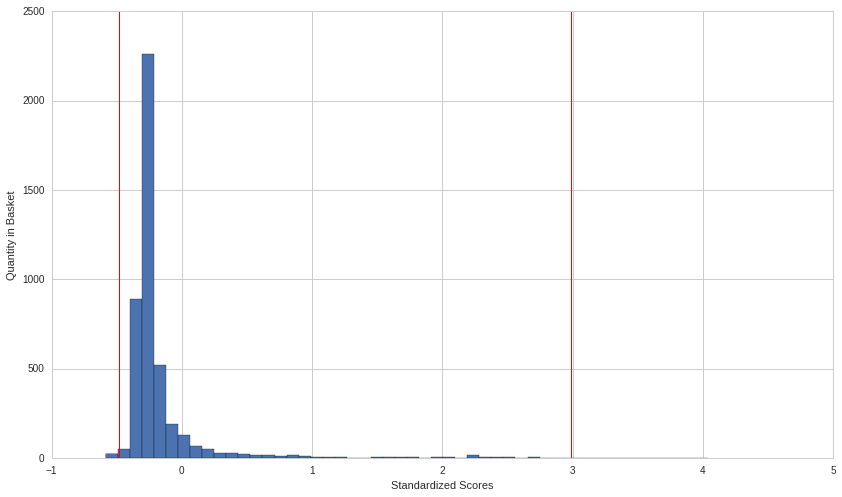

In [10]:
# create the histogram
ranked_scores.hist(bins=50)

# make scores into list for ease of manipulation
ranked_scores_list = ranked_scores.tolist()

# add labels to axes
plt.xlabel('Standardized Scores')
plt.ylabel('Quantity in Basket')

# show long bucket
plt.axvline(x=ranked_scores_list[25], linewidth=1, color='r')

# show short bucket
plt.axvline(x=ranked_scores_list[-6], linewidth=1, color='r');

Although it is clear that the long and short baskets are removed from the larger concentration of equities, it is also clear that the histogram is positively skewed, leaving a long tail to the right and a short tail to the left. However, closer inspection reveals a more worrying problem than just excess skewness.

Let us have a look at the sector makeup of our long basket. To do this, we will create a new Pipeline to extract the sector codes of the universe.

In [19]:
# create Pipeline for sectors
sector_pipe = Pipeline()
sector_pipe.add(Sector(), 'Sector')
sectors = run_pipeline(sector_pipe, '2015-06-06', '2015-06-06')

# connect ranked scores with their sectors
scores_sectors = pd.concat([ranked_scores, sectors], axis=1, join='inner')

# name the columns
scores_sectors.columns=['Score', 'Sector']

# sort ranked scores ascending
scores_sectors.sort('Score', inplace=True)

# show long bucket
scores_sectors.head(26)

,Score,Sector
"(2015-06-08 00:00:00+00:00, Equity(29375 [QKLS]))",-0.584313,205
"(2015-06-08 00:00:00+00:00, Equity(24831 [ESI]))",-0.581647,205
"(2015-06-08 00:00:00+00:00, Equity(39744 [BORN]))",-0.578041,205
"(2015-06-08 00:00:00+00:00, Equity(42464 [RNDY]))",-0.573479,205
"(2015-06-08 00:00:00+00:00, Equity(35012 [GRO]))",-0.568073,205
"(2015-06-08 00:00:00+00:00, Equity(26301 [DIT]))",-0.561397,205
"(2015-06-08 00:00:00+00:00, Equity(12765 [AOI]))",-0.555417,205
"(2015-06-08 00:00:00+00:00, Equity(24814 [DF]))",-0.547799,205
"(2015-06-08 00:00:00+00:00, Equity(24834 [CECO]))",-0.537287,205
"(2015-06-08 00:00:00+00:00, Equity(19817 [MTEX]))",-0.533288,205


Each of these securities has sector code 205 and therefore is involved in the Consumer Defensive sector (a subset of the retail space). Therefore, even though we tried to fight this through industry-relative metrics, it seems that the immense skew of these values has made them ineffectual. 

This means we need to go back to the drawing board. Where did we start? We wanted to trade based on values that were attractive in their own industry. To achieve this goal, given the fact that a single ranking system has not worked, we will need to effectively create baskets for each industry and then take out a 130/30 position in each of them. 

To do this we will first need to declare a dictionary of sector codes and sectors, loop through this dictionary and create long and short baskets for each industry.

In [18]:
SECTOR_NAMES = {
 101: 'Basic Materials',
 102: 'Consumer Cyclical',
 103: 'Financial Services',
 104: 'Real Estate',
 205: 'Consumer Defensive',
 206: 'Healthcare',
 207: 'Utilities',
 308: 'Communication Services',
 309: 'Energy',
 310: 'Industrials',
 311: 'Technology' ,
}

# create and populate the buckets
long_bucket = pd.Series()
short_bucket = pd.Series()
for key in SECTOR_NAMES:
    long_bucket = long_bucket.append(scores_sectors[scores_sectors['Sector'] == key]['Score'].head(13))
    short_bucket = short_bucket.append(scores_sectors[scores_sectors['Sector'] == key]['Score'].tail(3))        

print 'LONG BUCKET\n' + str(long_bucket) + '\n'
print 'SHORT BUCKET\n' + str(short_bucket)

LONG BUCKET
(2015-06-08 00:00:00+00:00, Equity(29375 [QKLS]))    -0.584313
(2015-06-08 00:00:00+00:00, Equity(24831 [ESI]))     -0.581647
(2015-06-08 00:00:00+00:00, Equity(39744 [BORN]))    -0.578041
(2015-06-08 00:00:00+00:00, Equity(42464 [RNDY]))    -0.573479
(2015-06-08 00:00:00+00:00, Equity(35012 [GRO]))     -0.568073
(2015-06-08 00:00:00+00:00, Equity(26301 [DIT]))     -0.561397
(2015-06-08 00:00:00+00:00, Equity(12765 [AOI]))     -0.555417
(2015-06-08 00:00:00+00:00, Equity(24814 [DF]))      -0.547799
(2015-06-08 00:00:00+00:00, Equity(24834 [CECO]))    -0.537287
(2015-06-08 00:00:00+00:00, Equity(19817 [MTEX]))    -0.533288
(2015-06-08 00:00:00+00:00, Equity(30017 [LFVN]))    -0.532106
(2015-06-08 00:00:00+00:00, Equity(29228 [SPU]))     -0.524994
(2015-06-08 00:00:00+00:00, Equity(14329 [ANDE]))    -0.520449
(2015-06-08 00:00:00+00:00, Equity(30851 [SKBI]))    -0.346147
(2015-06-08 00:00:00+00:00, Equity(2561 [ENZN]))     -0.346014
(2015-06-08 00:00:00+00:00, Equity(13331 [A

Although this is a valid way to create an industry-relative strategy, I would argue that this solution is inelegant. The real issue with this strategy is its skewness. Standardization is more effective the closer the underlying distribution is to being Normal. Here, it is not very effective at all. However, the data *could* be manipulated to be more Normal through transformations such as reciprocals, logs, roots etc. I will leave it to the reader to experiment with these transformations and thereby create a more robust metric.

It is important to realize when a strategy just will not work. Even if the basic idea is sound and the process used to rank the universe and trade the strategy is solid, some algorithms just do not work in practice. You should only be trading strategies that you are confident in, and I would encourage thorough examination of any algorithm from all angles before letting it loose on the market. 

Please see the full algorithm for backtested returns!

*The material on this website is provided for informational purposes only and does not constitute an offer to sell, a solicitation to buy, or a recommendation or endorsement for any security or strategy, nor does it constitute an offer to provide investment advisory or other services by Quantopian.*

*In addition, the content of the website neither constitutes investment advice nor offers any opinion with respect to the suitability of any security or any specific investment. Quantopian makes no guarantees as to accuracy or completeness of the views expressed in the website. The views are subject to change, and may have become unreliable for various reasons, including changes in market conditions or economic circumstances.*